<a href="https://colab.research.google.com/github/balams81/Rain/blob/master/Introduction_to_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction to Logistic Regression**

In [1]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [2]:
# Hyperparmeters
batch_size = 128
learning_rate = 0.001

# Other constants
input_size = 28*28
num_classes = 10

In [3]:
# Download dataset
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)

# Training validation & test dataset
train_ds, val_ds = random_split(dataset, [50000, 10000])
test_ds = MNIST(root='data/', train=False, transform=transforms.ToTensor())

# Dataloaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_ds, batch_size*2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
test_ds = MNIST(root='data/', train=False, transform=transforms.ToTensor())

In [5]:
len(test_ds)

10000

In [6]:
len(dataset)

60000

Label: 1


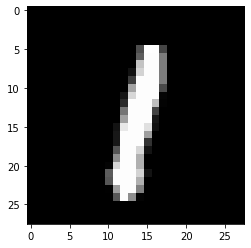

In [7]:
image, label = train_ds[102]
plt.imshow(image[0], cmap='gray')
print('Label:', label)

In [8]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

In [9]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [10]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [11]:
evaluate(model, val_loader)

{'val_acc': 0.06855468451976776, 'val_loss': 2.3246054649353027}

In [12]:
history = fit(50, 0.0001, model, train_loader, val_loader)

Epoch [0], val_loss: 2.2817, val_acc: 0.1049
Epoch [1], val_loss: 2.2404, val_acc: 0.1681
Epoch [2], val_loss: 2.2007, val_acc: 0.2489
Epoch [3], val_loss: 2.1624, val_acc: 0.3354
Epoch [4], val_loss: 2.1253, val_acc: 0.4095
Epoch [5], val_loss: 2.0894, val_acc: 0.4819
Epoch [6], val_loss: 2.0546, val_acc: 0.5438
Epoch [7], val_loss: 2.0208, val_acc: 0.5841
Epoch [8], val_loss: 1.9880, val_acc: 0.6111
Epoch [9], val_loss: 1.9562, val_acc: 0.6333
Epoch [10], val_loss: 1.9254, val_acc: 0.6516
Epoch [11], val_loss: 1.8954, val_acc: 0.6649
Epoch [12], val_loss: 1.8663, val_acc: 0.6764
Epoch [13], val_loss: 1.8381, val_acc: 0.6853
Epoch [14], val_loss: 1.8106, val_acc: 0.6922
Epoch [15], val_loss: 1.7840, val_acc: 0.6985
Epoch [16], val_loss: 1.7582, val_acc: 0.7058
Epoch [17], val_loss: 1.7331, val_acc: 0.7106
Epoch [18], val_loss: 1.7087, val_acc: 0.7181
Epoch [19], val_loss: 1.6850, val_acc: 0.7244
Epoch [20], val_loss: 1.6621, val_acc: 0.7274
Epoch [21], val_loss: 1.6398, val_acc: 0.730

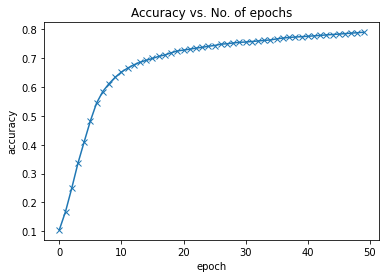

In [13]:
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [14]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_acc': 0.8052734136581421, 'val_loss': 1.1852163076400757}

In [15]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 6 , Predicted: 6


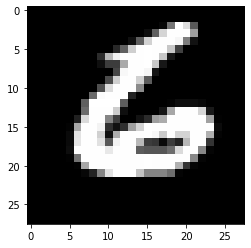

In [20]:
img, label = test_ds[9999]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [21]:
torch.save(model.state_dict(), 'mnist-logistic.pth')